In [1]:
import numpy as np
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")
with h5py.File(CUBE_PATH, "r") as cube:
    metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
metadata_indices = metadata[:, 0]["ds_slice_idx"]

# Data exploration and processing:

Total records in sfrs (before filtering by image/spectrum): 34613
Total records after filtering by image/spectrum availability: 34613
Total records after removing NaN in AVG: 34613
Total records after filtering AVG >= -80: 30752
Among them, FLAG == 0: 16841
Among them, FLAG != 0: 13911


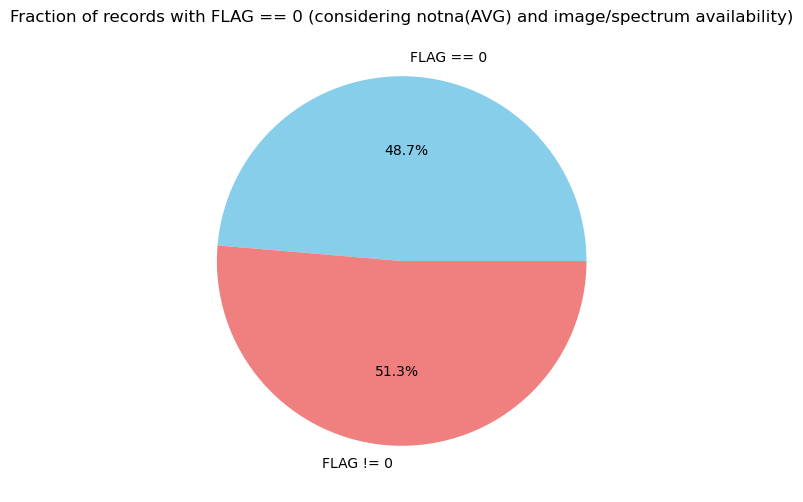

In [5]:
sfrs = sfrs[sfrs.index.isin(metadata_indices)].copy()
sfrs = sfrs[sfrs["AVG"].notna()].copy()
sfrs_filtered = sfrs[sfrs["AVG"] >= -80].copy()
sfrs_flag0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] == 0.0].copy()
sfrs_flag_not0_filtered = sfrs_filtered[sfrs_filtered["FLAG"] != 0.0].copy()

print("Total records in sfrs (before filtering by image/spectrum):", len(sfrs))
print("Total records after filtering by image/spectrum availability:", len(sfrs))
print("Total records after removing NaN in AVG:", len(sfrs))
print("Total records after filtering AVG >= -80:", len(sfrs_filtered))
print("Among them, FLAG == 0:", len(sfrs_flag0_filtered))
print("Among them, FLAG != 0:", len(sfrs_flag_not0_filtered))

sfrs_flag0 = sfrs[sfrs["FLAG"] == 0.0]
labels_pie = ["FLAG == 0", "FLAG != 0"]
sizes = [len(sfrs_flag0), len(sfrs) - len(sfrs_flag0)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=["skyblue", "lightcoral"])
plt.title("Fraction of records with FLAG == 0 (considering notna(AVG) and image/spectrum availability)")
plt.show()

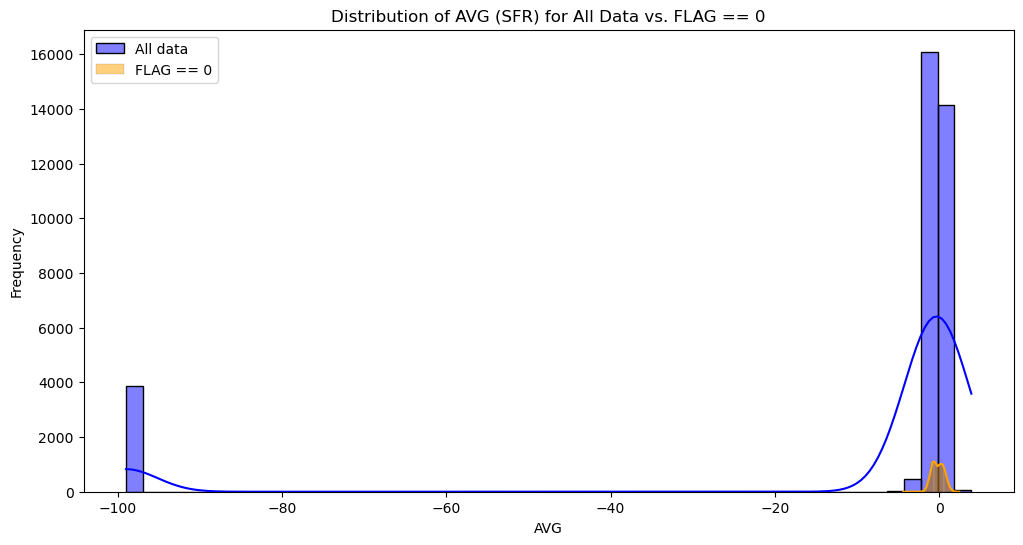

In [6]:
plt.figure(figsize=(12,6))
sns.histplot(sfrs["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

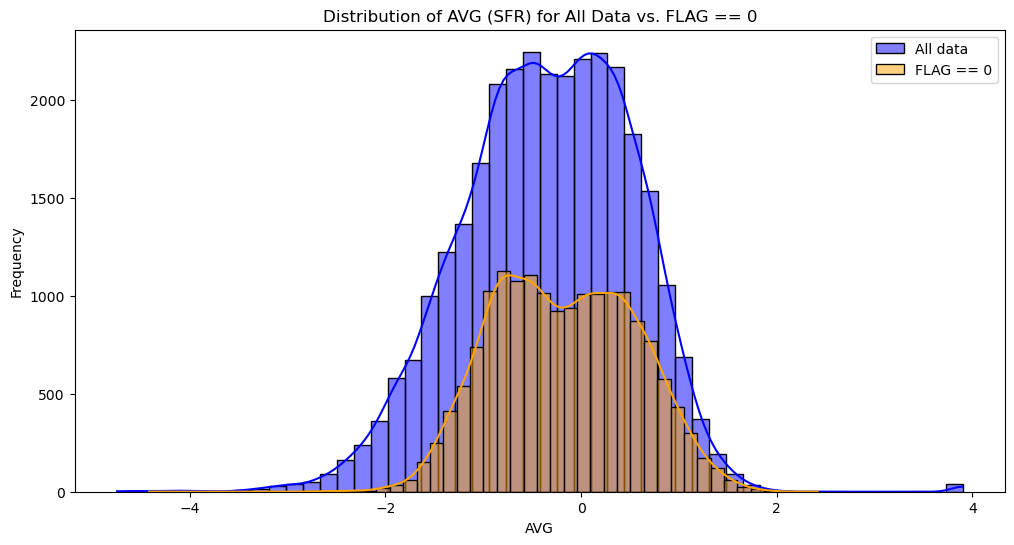

In [7]:
plt.figure(figsize=(12,6))
sns.histplot(sfrs_filtered["AVG"].dropna(), bins=50, color="blue", label="All data", kde=True)
sns.histplot(sfrs_flag0_filtered["AVG"].dropna(), bins=50, color="orange", label="FLAG == 0", kde=True)
plt.legend()
plt.title("Distribution of AVG (SFR) for All Data vs. FLAG == 0")
plt.xlabel("AVG")
plt.ylabel("Frequency")
plt.show()

In [8]:
mask_all = np.in1d(metadata_indices, sfrs_filtered.index)
mask_flag0 = np.in1d(metadata_indices, sfrs_flag0_filtered.index)
selected_all = metadata_indices[mask_all]
selected_flag0 = metadata_indices[mask_flag0]

all_images = []
all_spectra = []
filtered_images = []
filtered_spectra = []

for zoom in range(4):
    img_key = f"dense_cube/{zoom}/ml_image/cutout_3d_cube_zoom_{zoom}"
    spec_key = f"dense_cube/{zoom}/ml_spectrum/spectral_1d_cube_zoom_{zoom}"
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom = cube[img_key][:][mask_all]
        spectra_zoom = cube[spec_key][:][mask_all]
    all_images.append(images_zoom)
    all_spectra.append(spectra_zoom)
    with h5py.File(CUBE_PATH, "r") as cube:
        images_zoom_flag0 = cube[img_key][:][mask_flag0]
        spectra_zoom_flag0 = cube[spec_key][:][mask_flag0]
    filtered_images.append(images_zoom_flag0)
    filtered_spectra.append(spectra_zoom_flag0)

print("All images shape (zoom 0):", all_images[0].shape)
print("Filtered images shape (zoom 0):", filtered_images[0].shape)
print("All spectra shape (zoom 0):", all_spectra[0].shape)
print("Filtered spectra shape (zoom 0):", filtered_spectra[0].shape)

All images shape (zoom 0): (30752, 5, 64, 64)
Filtered images shape (zoom 0): (16841, 5, 64, 64)
All spectra shape (zoom 0): (30752, 4620)
Filtered spectra shape (zoom 0): (16841, 4620)


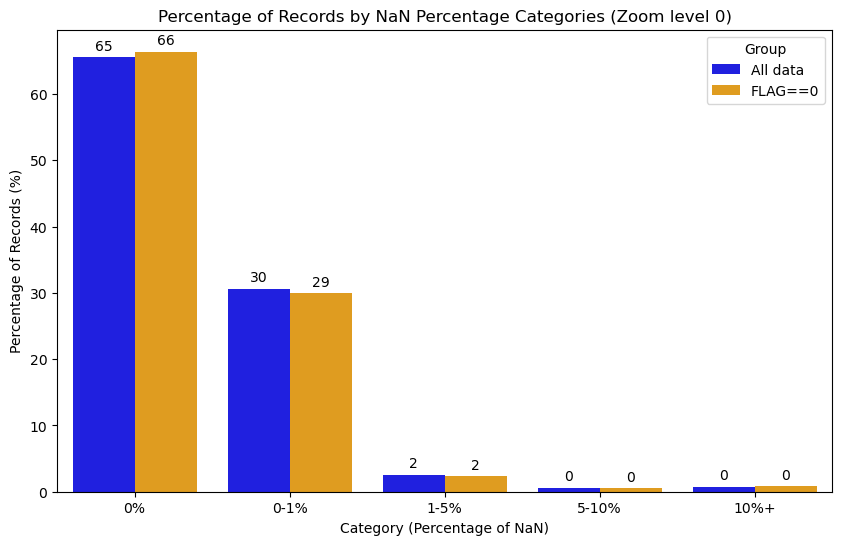

In [9]:
nan_counts_all = np.sum(np.isnan(all_spectra[0]), axis=1)
nan_counts_flag0 = np.sum(np.isnan(filtered_spectra[0]), axis=1)
total_length = all_spectra[0].shape[1]

def categorize_nan_percentage(nan_counts, total_length):
    percentages = (nan_counts / total_length) * 100
    categories = []
    for p in percentages:
        if p == 0:
            categories.append("0%")
        elif p <= 1:
            categories.append("0-1%")
        elif p <= 5:
            categories.append("1-5%")
        elif p <= 10:
            categories.append("5-10%")
        else:
            categories.append("10%+")
    return categories

categories_all = categorize_nan_percentage(nan_counts_all, total_length)
categories_flag0 = categorize_nan_percentage(nan_counts_flag0, total_length)

df_all = pd.DataFrame({"NaN_Category": categories_all, "Group": "All data"})
df_flag0 = pd.DataFrame({"NaN_Category": categories_flag0, "Group": "FLAG==0"})
df_nan = pd.concat([df_all, df_flag0], ignore_index=True)

category_order = ["0%", "0-1%", "1-5%", "5-10%", "10%+"]

grouped = df_nan.groupby(["Group", "NaN_Category"]).size().reset_index(name="count")
total_counts_df = df_nan.groupby("Group").size().reset_index(name="total")
merged = pd.merge(grouped, total_counts_df, on="Group")
merged["percent"] = merged["count"] / merged["total"] * 100

merged["NaN_Category"] = pd.Categorical(merged["NaN_Category"], categories=category_order, ordered=True)
merged = merged.sort_values(["Group", "NaN_Category"])

plt.figure(figsize=(10,6))
ax = sns.barplot(data=merged, x="NaN_Category", y="percent", hue="Group", 
                 order=category_order, palette=["blue", "orange"])
plt.title("Percentage of Records by NaN Percentage Categories (Zoom level 0)")
plt.xlabel("Category (Percentage of NaN)")
plt.ylabel("Percentage of Records (%)")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
plt.show()

Zoom level 0 (FLAG == 0): found 12207 NaN blocks, average length = 34.69, max = 4620
Zoom level 0 (FLAG != 0): found 24076 NaN blocks, average length = 31.97, max = 4620
Zoom level 1 (FLAG == 0): found 12045 NaN blocks, average length = 18.11, max = 2310
Zoom level 1 (FLAG != 0): found 23793 NaN blocks, average length = 16.70, max = 2310
Zoom level 2 (FLAG == 0): found 11954 NaN blocks, average length = 9.68, max = 1155
Zoom level 2 (FLAG != 0): found 23621 NaN blocks, average length = 8.96, max = 1155
Zoom level 3 (FLAG == 0): found 11875 NaN blocks, average length = 5.46, max = 577
Zoom level 3 (FLAG != 0): found 23448 NaN blocks, average length = 5.11, max = 577


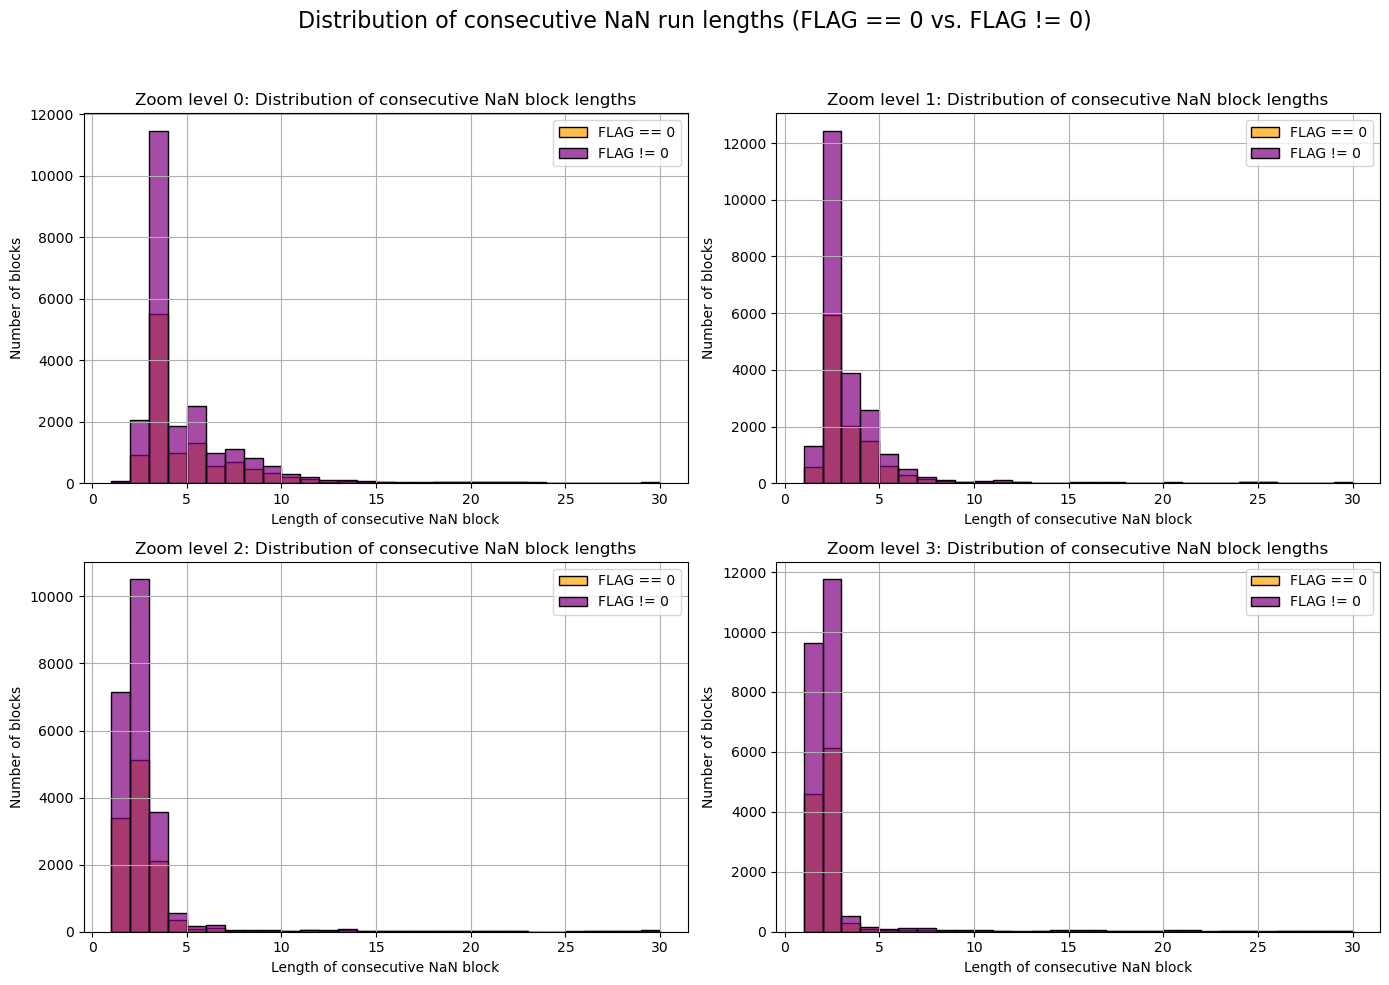

In [10]:
def get_run_lengths(bool_arr):
    diff = np.diff(np.concatenate(([0], bool_arr.astype(int), [0])))
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return ends - starts

run_lengths_flag0_by_zoom = []
run_lengths_flag_not0_by_zoom = []

for zoom in range(4):
    runs_flag0 = []
    runs_flag_not0 = []
    
    for row in filtered_spectra[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag0.extend(run_lengths)
    run_lengths_flag0_by_zoom.append(np.array(runs_flag0))
    
    for row in all_spectra[zoom]:
        run_lengths = get_run_lengths(np.isnan(row))
        if run_lengths.size > 0:
            runs_flag_not0.extend(run_lengths)
    run_lengths_flag_not0_by_zoom.append(np.array(runs_flag_not0))
    
    print(f"Zoom level {zoom} (FLAG == 0): found {len(runs_flag0)} NaN blocks, "
          f"average length = {np.mean(runs_flag0) if len(runs_flag0)>0 else 0:.2f}, "
          f"max = {np.max(runs_flag0) if len(runs_flag0)>0 else 0}")
    print(f"Zoom level {zoom} (FLAG != 0): found {len(runs_flag_not0)} NaN blocks, "
          f"average length = {np.mean(runs_flag_not0) if len(runs_flag_not0)>0 else 0:.2f}, "
          f"max = {np.max(runs_flag_not0) if len(runs_flag_not0)>0 else 0}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
bins = np.arange(1, 31)  

for i in range(4):
    ax = axes[i]
    sns.histplot(
        run_lengths_flag0_by_zoom[i],
        bins=bins,
        color="orange",
        label="FLAG == 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    sns.histplot(
        run_lengths_flag_not0_by_zoom[i],
        bins=bins,
        color="purple",
        label="FLAG != 0",
        kde=False,
        stat="count",
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Zoom level {i}: Distribution of consecutive NaN block lengths")
    ax.set_xlabel("Length of consecutive NaN block")
    ax.set_ylabel("Number of blocks")
    ax.legend()
    ax.grid(True)

plt.suptitle("Distribution of consecutive NaN run lengths (FLAG == 0 vs. FLAG != 0)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

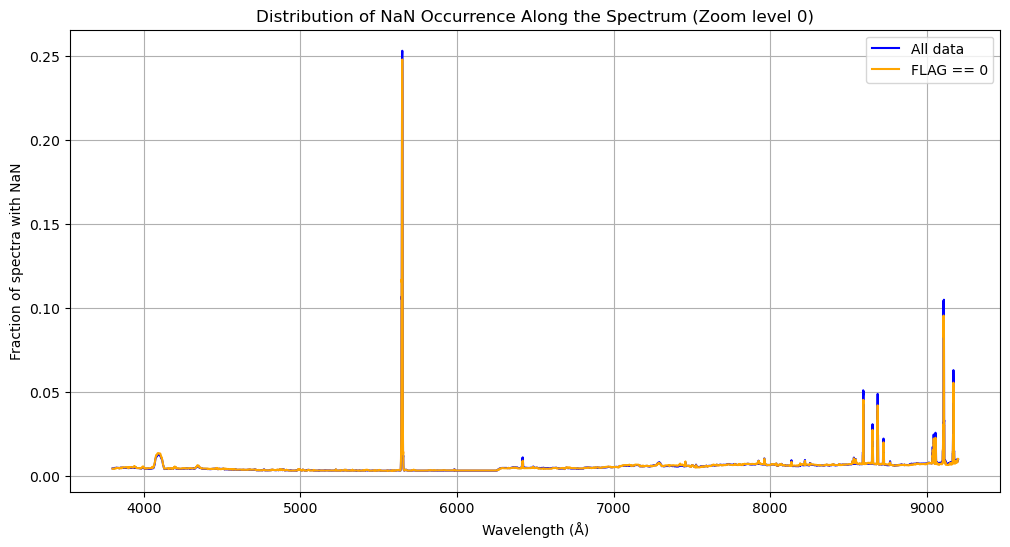

In [11]:
total_length = all_spectra[0].shape[1]
wavelengths = np.linspace(3800, 9200, total_length)

fraction_nan_all = np.mean(np.isnan(all_spectra[0]), axis=0)
fraction_nan_flag0 = np.mean(np.isnan(filtered_spectra[0]), axis=0)

plt.figure(figsize=(12,6))
plt.plot(wavelengths, fraction_nan_all, label="All data", color="blue", linewidth=1.5)
plt.plot(wavelengths, fraction_nan_flag0, label="FLAG == 0", color="orange", linewidth=1.5)
plt.xlabel("Wavelength (Å)")
plt.ylabel("Fraction of spectra with NaN")
plt.title("Distribution of NaN Occurrence Along the Spectrum (Zoom level 0)")
plt.legend()
plt.grid(True)
plt.show()


### Delete all the spectra that contain nan:

In [12]:
mask_clean_all = ~np.isnan(all_spectra[0]).any(axis=1)
mask_clean_flag0 = ~np.isnan(filtered_spectra[0]).any(axis=1)

cleaned_all_images = [arr[mask_clean_all] for arr in all_images]
cleaned_all_spectra = [arr[mask_clean_all] for arr in all_spectra]

cleaned_filtered_images = [arr[mask_clean_flag0] for arr in filtered_images]
cleaned_filtered_spectra = [arr[mask_clean_flag0] for arr in filtered_spectra]

selected_all_clean = selected_all[mask_clean_all]
selected_flag0_clean = selected_flag0[mask_clean_flag0]

cleaned_sfrs_all = sfrs_filtered.loc[selected_all_clean]
cleaned_sfrs_flag0 = sfrs_flag0_filtered.loc[selected_flag0_clean]

print("Cleaned All spectra shape (zoom 0):", cleaned_all_spectra[0].shape)
print("Cleaned FLAG==0 spectra shape (zoom 0):", cleaned_filtered_spectra[0].shape)
print("Spectra removed (all):", all_spectra[0].shape[0] - cleaned_all_spectra[0].shape[0])
print("Spectra removed (FLAG==0):", filtered_spectra[0].shape[0] - cleaned_filtered_spectra[0].shape[0])

print("\nCleaned All images shape (zoom 0):", cleaned_all_images[0].shape)
print("Cleaned FLAG==0 images shape (zoom 0):", cleaned_filtered_images[0].shape)
print("Images removed (all):", all_images[0].shape[0] - cleaned_all_images[0].shape[0])
print("Images removed (FLAG==0):", filtered_images[0].shape[0] - cleaned_filtered_images[0].shape[0])

print("\nCleaned SFR (all) shape:", cleaned_sfrs_all.shape)
print("Cleaned SFR (FLAG==0) shape:", cleaned_sfrs_flag0.shape)
print("SFR records removed (all):", sfrs_filtered.shape[0] - cleaned_sfrs_all.shape[0])
print("SFR records removed (FLAG==0):", sfrs_flag0_filtered.shape[0] - cleaned_sfrs_flag0.shape[0])


Cleaned All spectra shape (zoom 0): (20157, 4620)
Cleaned FLAG==0 spectra shape (zoom 0): (11179, 4620)
Spectra removed (all): 10595
Spectra removed (FLAG==0): 5662

Cleaned All images shape (zoom 0): (20157, 5, 64, 64)
Cleaned FLAG==0 images shape (zoom 0): (11179, 5, 64, 64)
Images removed (all): 10595
Images removed (FLAG==0): 5662

Cleaned SFR (all) shape: (20157, 284)
Cleaned SFR (FLAG==0) shape: (11179, 284)
SFR records removed (all): 10595
SFR records removed (FLAG==0): 5662


In [13]:
def normalize_images(images_list):
    normalized_list = []
    for img_array in images_list:
        min_val = np.min(img_array, axis=(2,3), keepdims=True)
        max_val = np.max(img_array, axis=(2,3), keepdims=True)
        norm_img = 2 * (img_array - min_val) / (max_val - min_val) - 1
        normalized_list.append(norm_img)
    return normalized_list

normalized_all_images = normalize_images(cleaned_all_images)
normalized_filtered_images = normalize_images(cleaned_filtered_images)

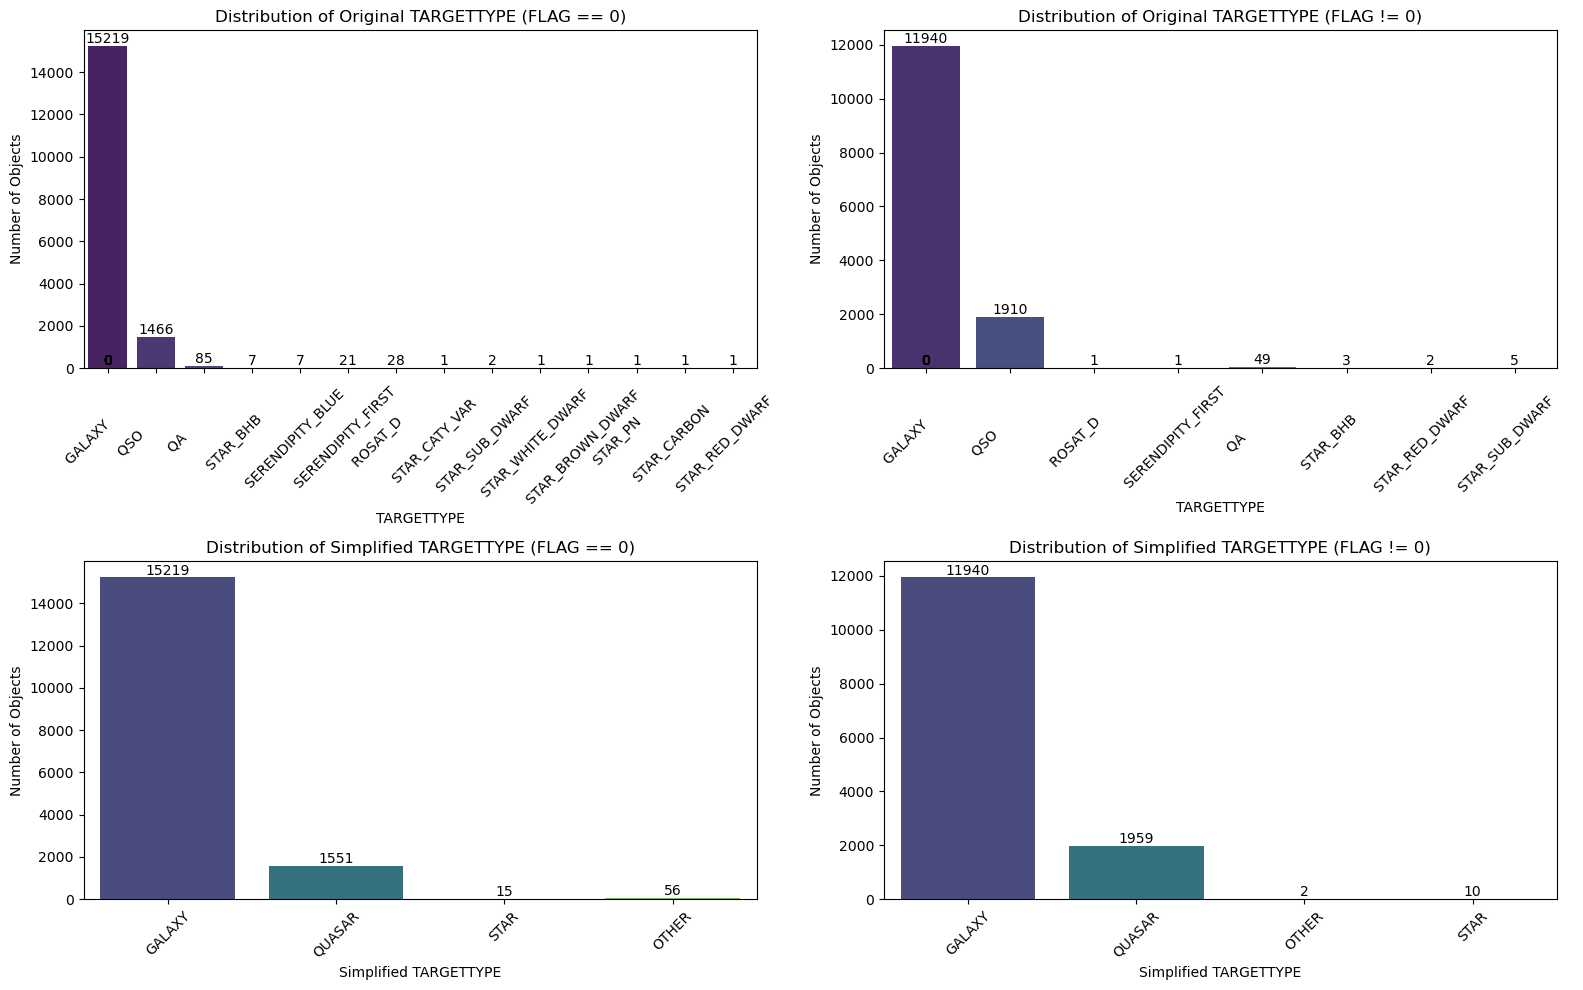

In [14]:
labels_flag0 = sfrs_flag0_filtered.loc[:, "TARGETTYPE"]
labels_flag_not0 = sfrs_filtered.loc[sfrs_filtered["FLAG"] != 0.0, "TARGETTYPE"]

def simplify_targettype(val):
    if isinstance(val, bytes):
        val = val.decode("utf-8").strip()
    else:
        val = str(val).strip()
    if "GALAXY" in val:
        return "GALAXY"
    elif "QSO" in val or "QA" in val:
        return "QUASAR"
    elif "STAR" in val:
        return "STAR"
    else:
        return "OTHER"

df_flag0_orig = pd.DataFrame({"TARGETTYPE": labels_flag0})
df_flag_not0_orig = pd.DataFrame({"TARGETTYPE": labels_flag_not0})

df_flag0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag0).apply(simplify_targettype)})
df_flag_not0_simpl = pd.DataFrame({"Simplified_TARGETTYPE": pd.Series(labels_flag_not0).apply(simplify_targettype)})

plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=df_flag0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax1)
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
ax1.set_title("Distribution of Original TARGETTYPE (FLAG == 0)")
ax1.set_xlabel("TARGETTYPE")
ax1.set_ylabel("Number of Objects")
ax1.tick_params(axis='x', labelrotation=45)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=df_flag_not0_orig, x="TARGETTYPE", hue="TARGETTYPE", dodge=False, palette="viridis", ax=ax2)
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
ax2.set_title("Distribution of Original TARGETTYPE (FLAG != 0)")
ax2.set_xlabel("TARGETTYPE")
ax2.set_ylabel("Number of Objects")
ax2.tick_params(axis='x', labelrotation=45)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=df_flag0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax3)
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
ax3.set_title("Distribution of Simplified TARGETTYPE (FLAG == 0)")
ax3.set_xlabel("Simplified TARGETTYPE")
ax3.set_ylabel("Number of Objects")
ax3.tick_params(axis='x', labelrotation=45)

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=df_flag_not0_simpl, x="Simplified_TARGETTYPE", hue="Simplified_TARGETTYPE", dodge=False, palette="viridis", ax=ax4)
if ax4.get_legend() is not None:
    ax4.get_legend().remove()
ax4.set_title("Distribution of Simplified TARGETTYPE (FLAG != 0)")
ax4.set_xlabel("Simplified TARGETTYPE")
ax4.set_ylabel("Number of Objects")
ax4.tick_params(axis='x', labelrotation=45)

for ax in [ax1, ax2, ax3, ax4]:
    for patch in ax.patches:
        ax.annotate(
            format(int(patch.get_height()), 'd'),
            (patch.get_x() + patch.get_width() / 2., patch.get_height()),
            ha='center', va='center', xytext=(0, 5), textcoords='offset points'
        )

plt.tight_layout()
plt.show()

In [15]:
def normalize_spectra(spectra_list):
    normalized_list = []
    for spec in spectra_list:
        if spec.ndim == 1:
            spec = spec[np.newaxis, :]
        min_val = np.nanmin(spec, axis=1, keepdims=True)
        max_val = np.nanmax(spec, axis=1, keepdims=True)
        diff = np.where((max_val - min_val)==0, 1, max_val - min_val)
        norm_spec = 2 * (spec - min_val) / diff - 1
        normalized_list.append(norm_spec)
    result = np.empty(len(normalized_list), dtype=object)
    for i, arr in enumerate(normalized_list):
        result[i] = arr
    return result

normalized_all_spectra = normalize_spectra(cleaned_all_spectra)
normalized_filtered_spectra = normalize_spectra(cleaned_filtered_spectra)

/tmp/ipykernel_3343484/2208282942.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


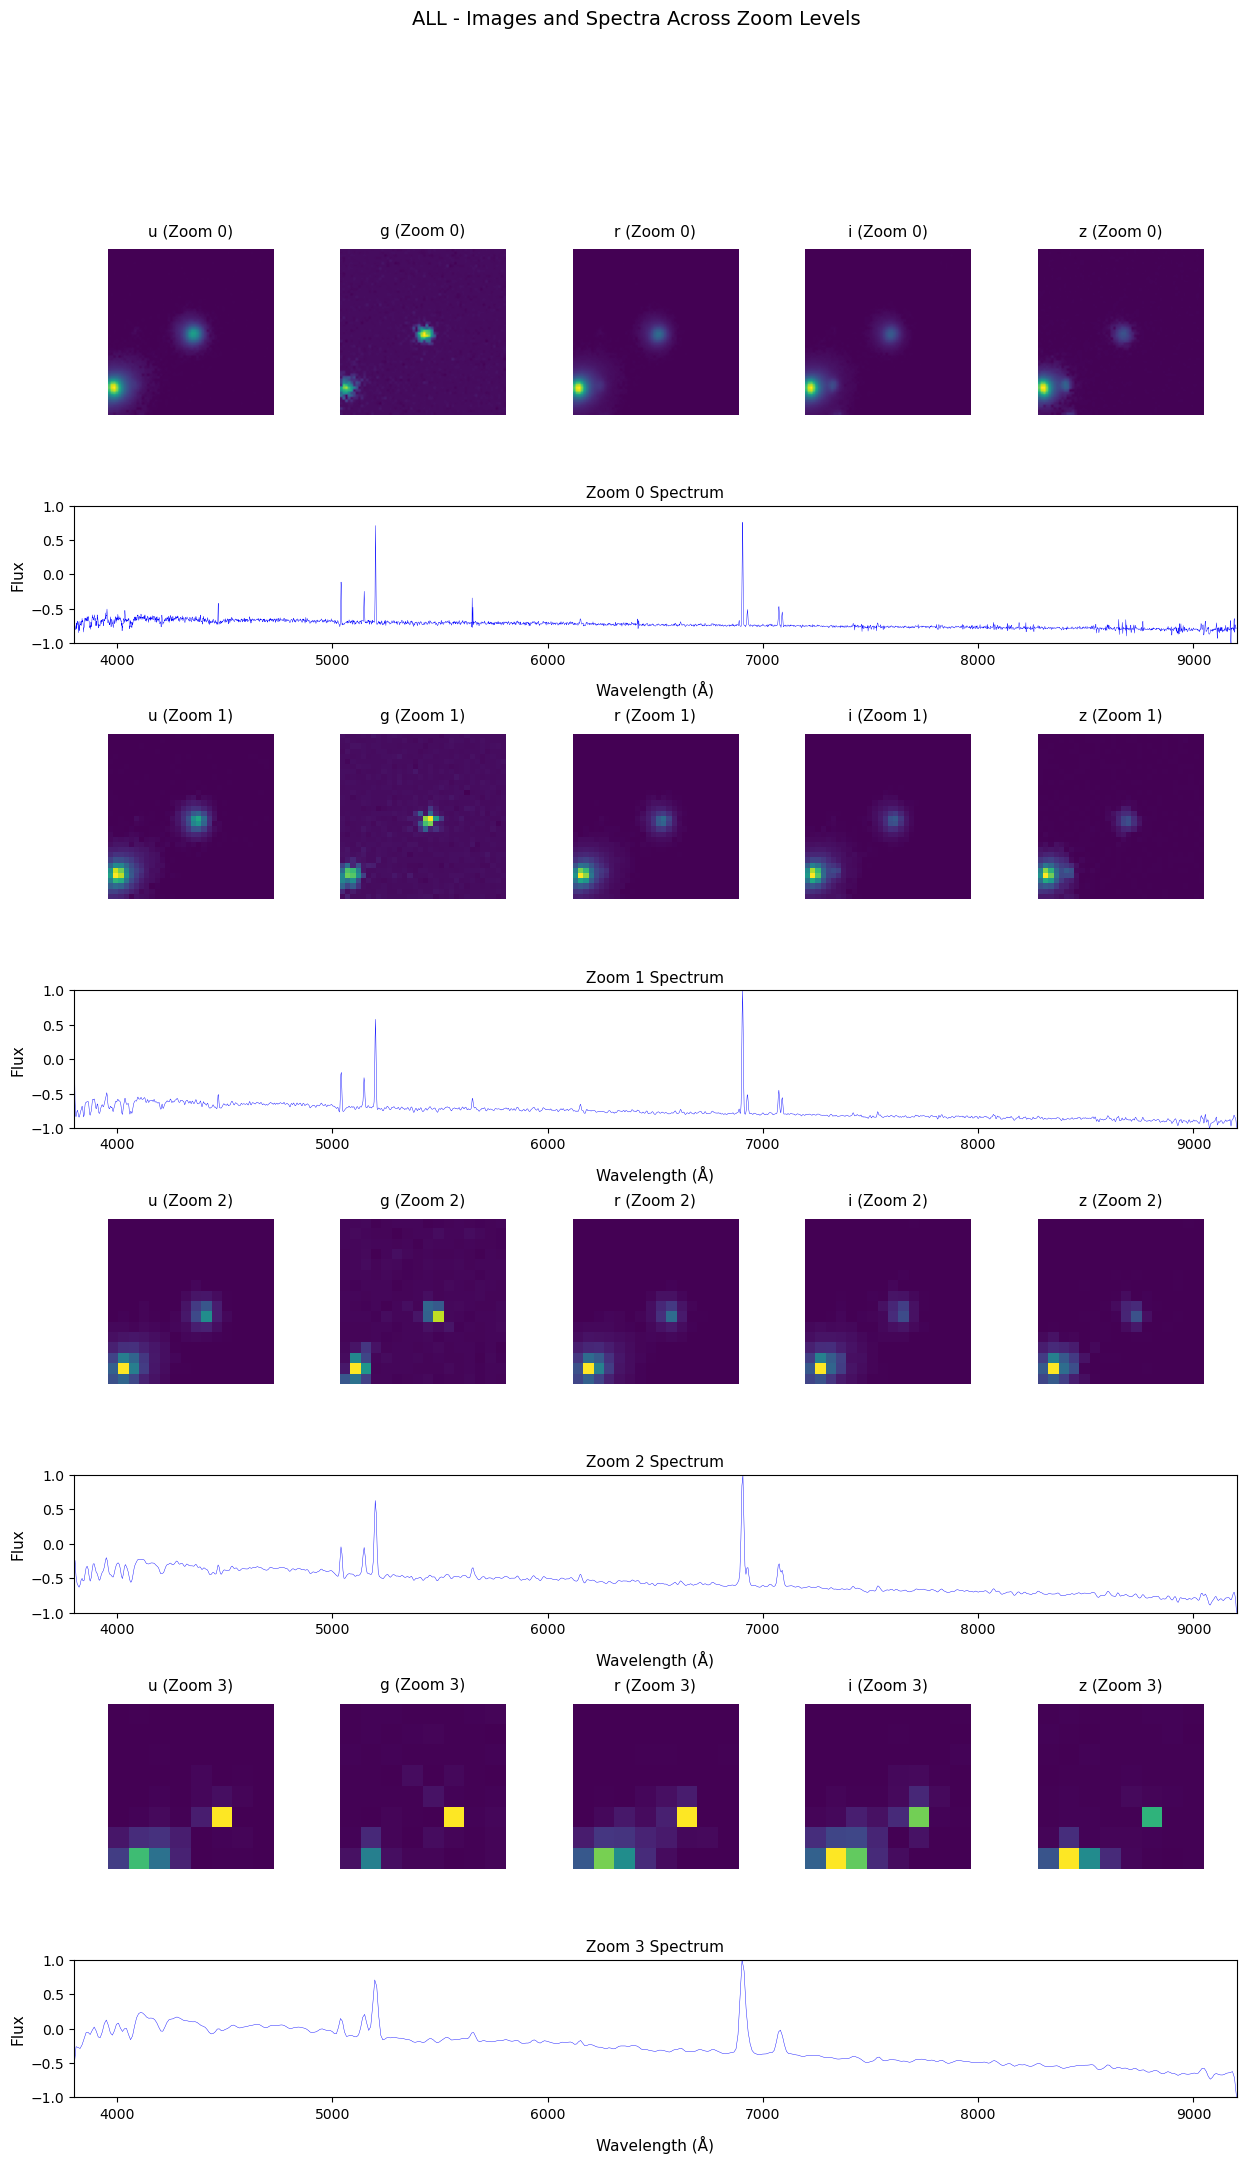

In [16]:
filters = ["u", "g", "r", "i", "z"]        

def plot_images_and_spectrum(images, spectra, labels, class_name, obj_num):
    if class_name.upper() == "ALL":
        class_index = np.arange(len(labels))
    else:
        simplified_labels = np.array([simplify_targettype(val) for val in labels])
        class_index = np.where(simplified_labels == class_name.upper())[0]
        if len(class_index) == 0:
            print(f"No images found for class: {class_name}")
            return

    if obj_num >= len(class_index):
        print(f"Object index {obj_num} is out of range. Max available: {len(class_index)-1}")
        return

    idx = class_index[obj_num]
    if len(images) < 4 or len(spectra) < 4:
        print(f"Expected 4 zoom levels, but got {len(images)} images and {len(spectra)} spectra.")
        return

    fig = plt.figure(figsize=(15, 24))
    gs = gridspec.GridSpec(8, 5, height_ratios=[1.2, 1.0, 1.2, 1.0, 1.2, 1.0, 1.2, 1.0],
                           hspace=0.6, wspace=0.0)

    for zoom in range(4):
        if idx >= images[zoom].shape[0]:
            print(f"Index {idx} is out of bounds for zoom {zoom} images.")
            continue

        img_channels = images[zoom][idx]
        spectrum = spectra[zoom][idx]

        for i in range(5):
            ax = fig.add_subplot(gs[zoom * 2, i])
            ax.imshow(img_channels[i], cmap="viridis")
            ax.set_title(f"{filters[i]} (Zoom {zoom})", fontsize=11, pad=10)
            ax.axis("off")

        ax_spec = fig.add_subplot(gs[zoom * 2 + 1, :])
        zoom_wavelengths = np.linspace(3800, 9200, len(spectrum))
        ax_spec.plot(zoom_wavelengths, spectrum, color="blue", linewidth=0.3)
        ax_spec.set_title(f"Zoom {zoom} Spectrum", fontsize=11)
        ax_spec.set_xlabel("Wavelength (Å)", fontsize=11, labelpad=10)
        ax_spec.set_ylabel("Flux", fontsize=11)
        ax_spec.set_xlim([3800, 9200])
        ax_spec.set_ylim([-1, 1])

    fig.suptitle(f"{class_name.upper()} - Images and Spectra Across Zoom Levels", fontsize=14)
    plt.tight_layout()
    plt.show()

for i in range(0, 1):
    plot_images_and_spectrum(cleaned_filtered_images, normalized_filtered_spectra, sfrs_filtered["TARGETTYPE"].values, "ALL", 0)

## Getting rid of photos with multiple objects:

In [17]:
flag0_indices = cleaned_sfrs_flag0.index
all_indices = cleaned_sfrs_all.index
flag_not0_indices = all_indices.difference(flag0_indices)
mask_flag_not0 = np.isin(cleaned_sfrs_all.index, flag_not0_indices)
normalized_nonflag0_images = [arr[mask_flag_not0] for arr in normalized_all_images]

In [18]:
CROP_SIZES_4 = {
    0: 32,  # originally 64
    1: 16,  # originally 32
    2: 8,   # originally 16
    3: 4    # originally 8
}
THRESHOLD = 0.9

def detect_and_visualize_multiple_objects(images_list, thresholds, crop_sizes=None, max_objects=1, thumbnail_size=3, group_name="", print_spectra=False, spectra_list=None):
    images_trimmed = []
    for i, img_array in enumerate(images_list):
        original_size = img_array.shape[-1]
        target_size = crop_sizes.get(i, original_size) if crop_sizes is not None else original_size
        start = (original_size - target_size) // 2
        end = start + target_size
        trimmed = img_array[..., start:end, start:end]
        images_trimmed.append(trimmed)
    multi_obj_indices = []
    for idx in range(images_trimmed[0].shape[0]):
        image = images_trimmed[0][idx, 2, :, :]
        image_normalized = (image + 1) / 2
        binary = image_normalized > thresholds
        labeled, num_features = ndimage.label(binary)
        if num_features > 1:
            multi_obj_indices.append(idx)
    total_images = images_trimmed[0].shape[0]
    count_multi = len(multi_obj_indices)
    percent_multi = (count_multi / total_images)*100 if total_images>0 else 0
    print(f"{group_name}: Found {count_multi} images with multiple objects from {total_images} ({percent_multi:.2f}%).")
    if multi_obj_indices:
        display_indices = multi_obj_indices[:max_objects]
        if print_spectra and spectra_list is not None:
            num_disp = len(display_indices)
            fig = plt.figure(figsize=(15, thumbnail_size * 2 * num_disp), dpi=100)
            gs = gridspec.GridSpec(2 * num_disp, 5, hspace=0.6, wspace=0.3)
            for i, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = fig.add_subplot(gs[2*i, col])
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
                ax_spec = fig.add_subplot(gs[2*i+1, :])
                spectrum = spectra_list[0][obj_idx]
                wavelengths = np.linspace(3800,9200, len(spectrum))
                ax_spec.plot(wavelengths, spectrum, color="blue", linewidth=0.3)
                ax_spec.set_title("Spectrum (Zoom 0)", fontsize=10)
                ax_spec.set_xlabel("Wavelength (Å)", fontsize=10)
                ax_spec.set_ylabel("Flux", fontsize=10)
                ax_spec.set_xlim([3800,9200])
                ax_spec.set_ylim([-1,1])
            fig.suptitle(f"Images with ≥2 objects and spectra ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.93)
            plt.show()
        else:
            num_disp = len(display_indices)
            fig, axes = plt.subplots(num_disp, 5, figsize=(15, thumbnail_size * num_disp), dpi=100)
            if num_disp == 1:
                axes = axes.reshape(1, -1)
            for row, obj_idx in enumerate(display_indices):
                for col in range(5):
                    ax = axes[row, col]
                    img_data = images_trimmed[0][obj_idx, col, :, :]
                    ax.imshow(img_data, vmin=-1, vmax=1)
                    ax.set_title(f"Filter {col}", fontsize=10)
                    ax.axis("off")
            fig.suptitle(f"Images with ≥2 objects ({group_name})", fontsize=14)
            fig.tight_layout()
            fig.subplots_adjust(top=0.99)
            plt.show()
    else:
        print(f"No images found for {group_name} with multiple objects.")
    return images_trimmed, multi_obj_indices

FLAG != 0 (Original): Found 1184 images with multiple objects from 8978 (13.19%).


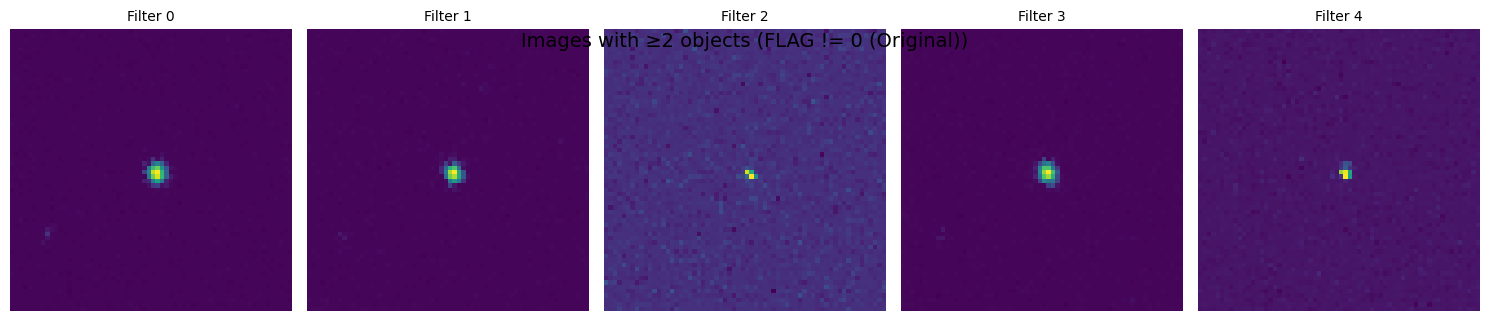

In [19]:
orig_images_flag_not0, multi_obj_indices_flag_not0 = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG != 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG == 0 (Original): Found 1111 images with multiple objects from 11179 (9.94%).


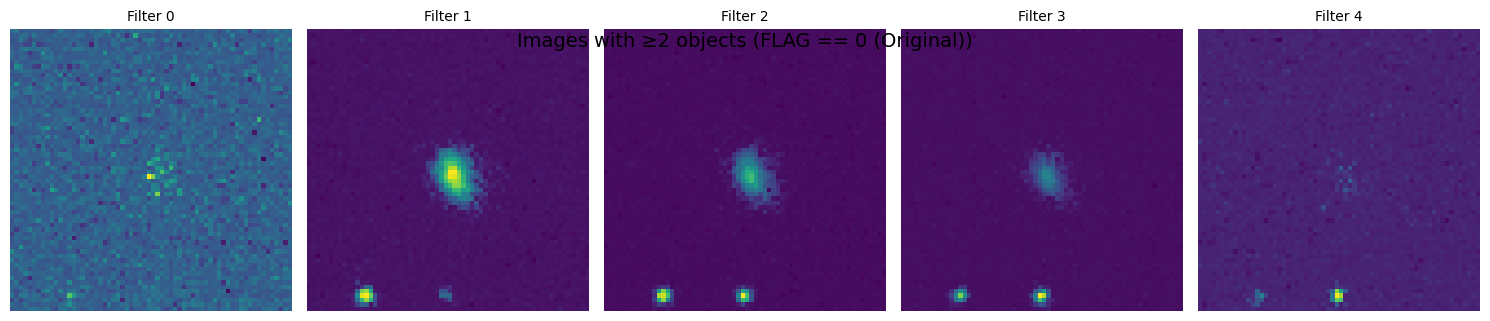

In [20]:
orig_images_flag0, multi_obj_indices_flag0 = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=None, group_name="FLAG == 0 (Original)", print_spectra=False, spectra_list=normalized_filtered_spectra)

### Cropped:

FLAG == 0 (Crop): Found 760 images with multiple objects from 11179 (6.80%).


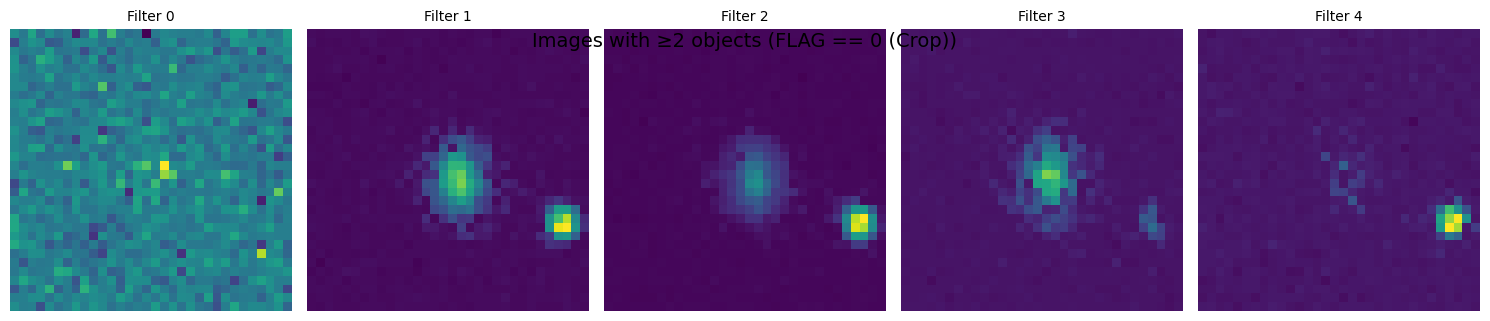

In [21]:
orig_images_flag0_crop, multi_obj_indices_flag0_crop = detect_and_visualize_multiple_objects(normalized_filtered_images, thresholds=THRESHOLD, crop_sizes=CROP_SIZES_4, group_name="FLAG == 0 (Crop)", print_spectra=False, spectra_list=normalized_filtered_spectra)

FLAG != 0 (Crop): Found 847 images with multiple objects from 8978 (9.43%).


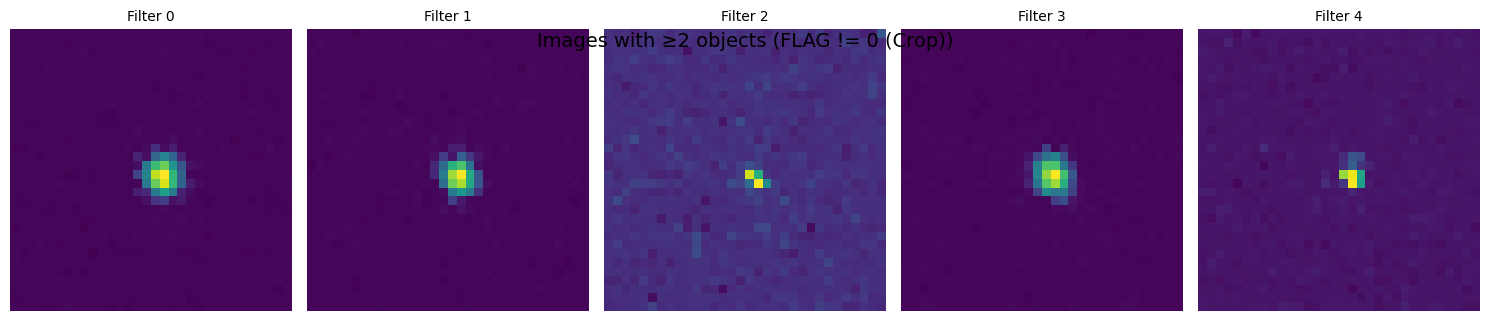

In [22]:
orig_images_flag_not0_crop, multi_obj_indices_flag_not0_crop = detect_and_visualize_multiple_objects(normalized_nonflag0_images, thresholds=THRESHOLD, crop_sizes=CROP_SIZES_4, group_name="FLAG != 0 (Crop)", print_spectra=False, spectra_list=normalized_filtered_spectra)

# Machine Learning (FLAG == 0 only):

## Decision tree:

In [23]:
param_grid = {
    'max_depth': [3, 5],
    'max_features': ['sqrt']
}

def run_grid_search(X, Y, param_grid):
    X_flat = X.reshape(X.shape[0], -1)
    X_train, X_val, Y_train, Y_val = train_test_split(X_flat, Y, test_size=0.2, random_state=42)
    model = DecisionTreeRegressor(random_state=42)
    grid = GridSearchCV(model, param_grid, scoring='r2', cv=5)
    grid.fit(X_train, Y_train)
    best_score = grid.best_score_
    best_params = grid.best_params_
    best_model = grid.best_estimator_
    y_val_pred = best_model.predict(X_val)
    mae = mean_absolute_error(Y_val, y_val_pred)
    r2 = r2_score(Y_val, y_val_pred)
    error = y_val_pred - Y_val
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    return best_score, best_params, mae, r2, nmad

selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values

results = {'Original Img': {}, 'Cropped Img': {}, 'Spectra': {}}

## Spectrum and Photo separately:

In [24]:
for zoom in range(4):
    X = orig_images_flag0[zoom]
    if X.shape[0] != len(selected_Y_flag0):
        Y_current = selected_Y_flag0[:X.shape[0]]
    else:
        Y_current = selected_Y_flag0
    best_score, best_params, mae, r2, nmad = run_grid_search(X, Y_current, param_grid)
    results['Original Img'][f'zoom_{zoom}'] = {'best_cv_score': best_score, 'best_params': best_params, 'mae': mae, 'r2': r2, 'nmad': nmad}
    print(f"Original Img zoom {zoom}: CV Score = {best_score:.3f}, Val MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")

Original Img zoom 0: CV Score = 0.108, Val MAE = 0.530, R2 = 0.144, NMAD = 0.657, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Original Img zoom 1: CV Score = 0.095, Val MAE = 0.546, R2 = 0.097, NMAD = 0.668, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Original Img zoom 2: CV Score = 0.053, Val MAE = 0.563, R2 = 0.065, NMAD = 0.703, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Original Img zoom 3: CV Score = 0.041, Val MAE = 0.580, R2 = 0.034, NMAD = 0.759, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}


In [25]:
for zoom in range(4):
    X = orig_images_flag0_crop[zoom]
    if X.shape[0] != len(selected_Y_flag0):
        Y_current = selected_Y_flag0[:X.shape[0]]
    else:
        Y_current = selected_Y_flag0
    best_score, best_params, mae, r2, nmad = run_grid_search(X, Y_current, param_grid)
    results['Cropped Img'][f'zoom_{zoom}'] = {'best_cv_score': best_score, 'best_params': best_params, 'mae': mae, 'r2': r2, 'nmad': nmad}
    print(f"Cropped Img zoom {zoom}: CV Score = {best_score:.3f}, Val MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")

Cropped Img zoom 0: CV Score = 0.111, Val MAE = 0.538, R2 = 0.122, NMAD = 0.669, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Cropped Img zoom 1: CV Score = 0.113, Val MAE = 0.543, R2 = 0.094, NMAD = 0.676, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Cropped Img zoom 2: CV Score = 0.066, Val MAE = 0.560, R2 = 0.069, NMAD = 0.702, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Cropped Img zoom 3: CV Score = 0.039, Val MAE = 0.575, R2 = 0.037, NMAD = 0.748, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}


In [26]:
for zoom in range(4):
    X = normalized_filtered_spectra[zoom]
    if X.shape[0] != len(selected_Y_flag0):
        Y_current = selected_Y_flag0[:X.shape[0]]
    else:
        Y_current = selected_Y_flag0
    best_score, best_params, mae, r2, nmad = run_grid_search(X, Y_current, param_grid)
    results['Spectra'][f'zoom_{zoom}'] = {'best_cv_score': best_score, 'best_params': best_params, 'mae': mae, 'r2': r2, 'nmad': nmad}
    print(f"Spectra zoom {zoom}: CV Score = {best_score:.3f}, Val MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")

Spectra zoom 0: CV Score = 0.010, Val MAE = 0.591, R2 = 0.028, NMAD = 0.790, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}
Spectra zoom 1: CV Score = 0.025, Val MAE = 0.589, R2 = 0.036, NMAD = 0.798, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}
Spectra zoom 2: CV Score = 0.023, Val MAE = 0.588, R2 = 0.039, NMAD = 0.797, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}
Spectra zoom 3: CV Score = 0.033, Val MAE = 0.587, R2 = 0.040, NMAD = 0.787, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}


## Visualization of results:

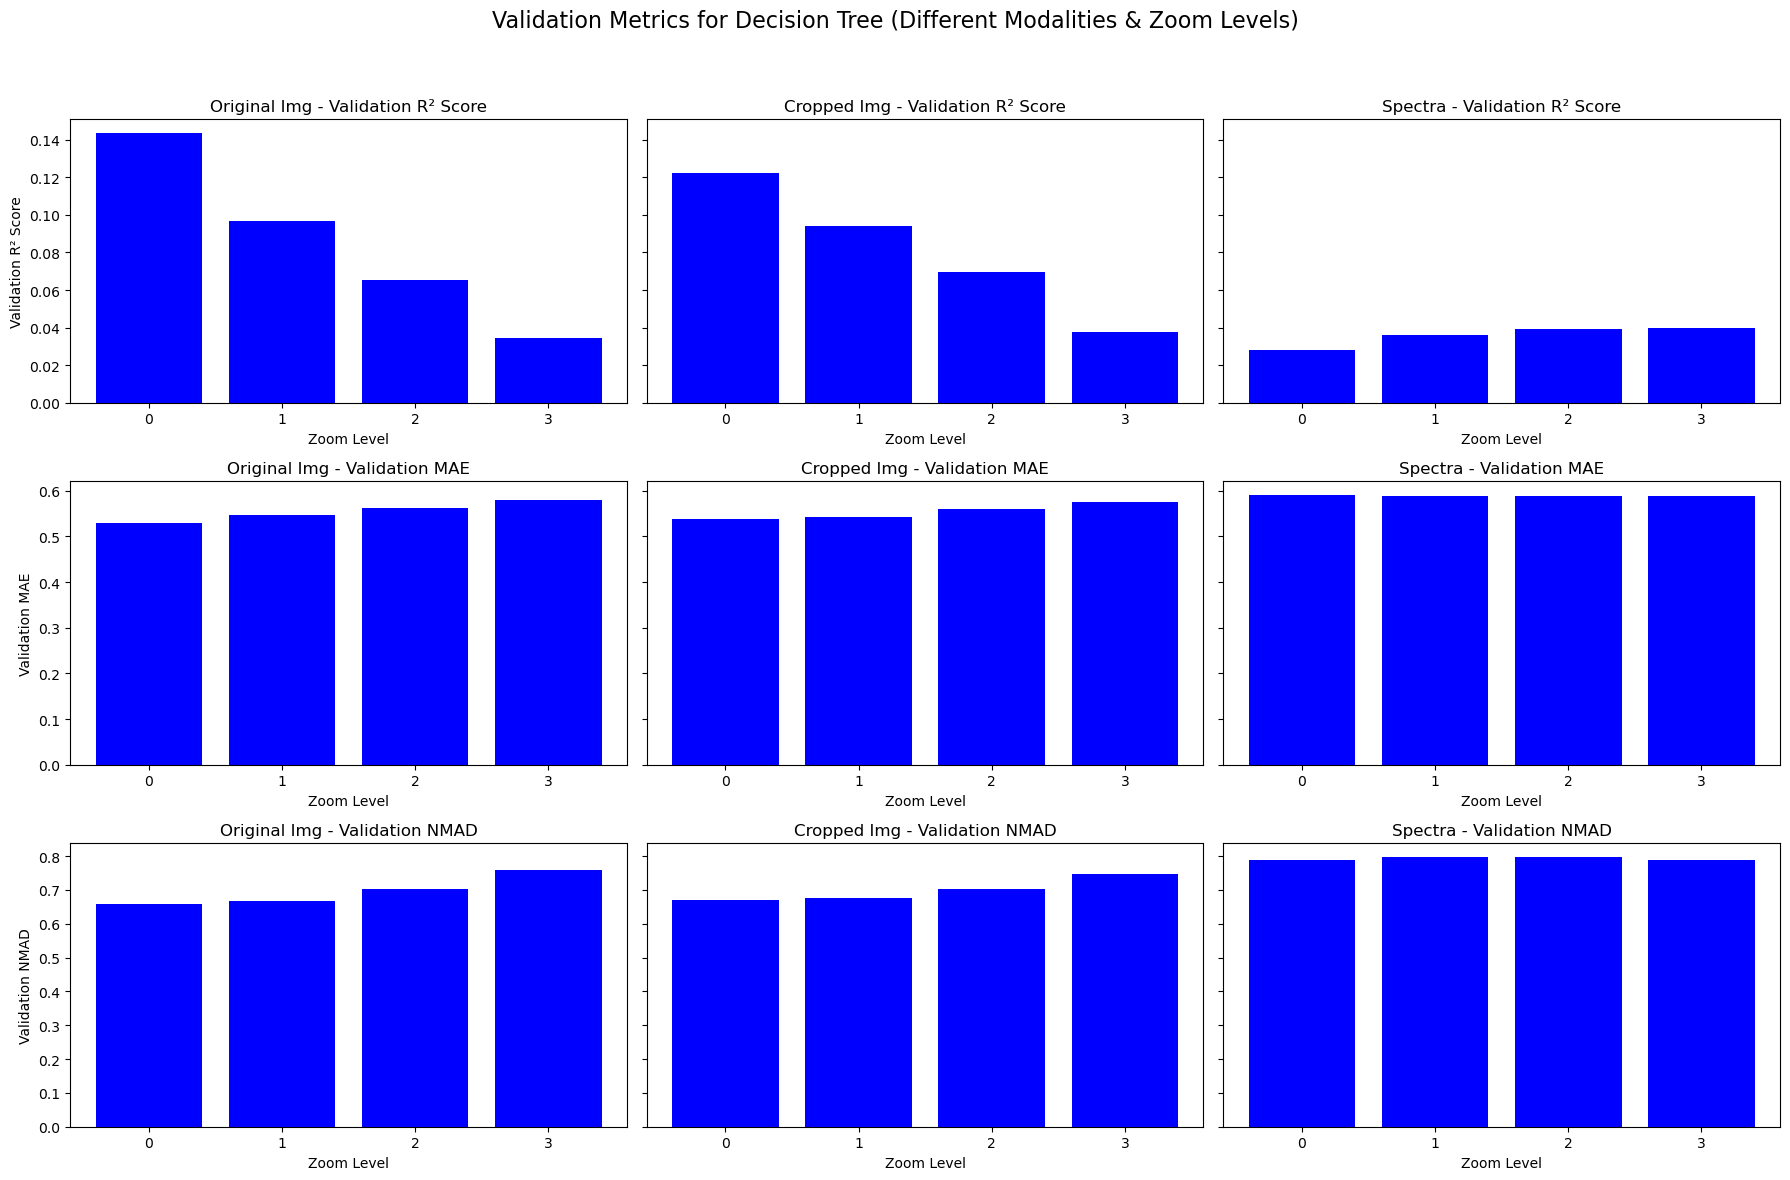

In [27]:
modalities = ['Original Img', 'Cropped Img', 'Spectra']
metrics = ['r2', 'mae', 'nmad']
titles = {'r2': 'Validation R² Score', 'mae': 'Validation MAE', 'nmad': 'Validation NMAD'}

fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharey='row')
for i, metric in enumerate(metrics):
    for j, modality in enumerate(modalities):
        zooms = []
        values = []
        for zoom in range(4):
            key = f'zoom_{zoom}'
            zooms.append(zoom)
            values.append(results[modality][key][metric])
        axs[i, j].bar(zooms, values, color='blue')
        axs[i, j].set_title(f"{modality} - {titles[metric]}")
        axs[i, j].set_xlabel("Zoom Level")
        axs[i, j].set_xticks(zooms)
        if j == 0:
            axs[i, j].set_ylabel(titles[metric])
plt.suptitle("Validation Metrics for Decision Tree (Different Modalities & Zoom Levels)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [28]:
for modality in modalities:
    print(f"\nTop 2 best results for {modality}:")
    sorted_results = sorted(results[modality].items(), key=lambda x: x[1]['r2'], reverse=True)
    for i in range(min(2, len(sorted_results))):
        zoom_key, res = sorted_results[i]
        print(f"{zoom_key}: Val MAE = {res['mae']:.3f}, R2 = {res['r2']:.3f}, NMAD = {res['nmad']:.3f}, Best Params = {res['best_params']}")


Top 2 best results for Original Img:
zoom_0: Val MAE = 0.530, R2 = 0.144, NMAD = 0.657, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
zoom_1: Val MAE = 0.546, R2 = 0.097, NMAD = 0.668, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}

Top 2 best results for Cropped Img:
zoom_0: Val MAE = 0.538, R2 = 0.122, NMAD = 0.669, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
zoom_1: Val MAE = 0.543, R2 = 0.094, NMAD = 0.676, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}

Top 2 best results for Spectra:
zoom_3: Val MAE = 0.587, R2 = 0.040, NMAD = 0.787, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}
zoom_2: Val MAE = 0.588, R2 = 0.039, NMAD = 0.797, Best Params = {'max_depth': 3, 'max_features': 'sqrt'}


## Multimodal:

In [29]:
multimodal_param_grid = {'max_depth': [3, 5], 'max_features': ['sqrt']}

photo_candidates = []
for zoom in range(4):
    candidate = ("Original Img", zoom, results['Original Img'][f'zoom_{zoom}']['mae'], orig_images_flag0[zoom])
    photo_candidates.append(candidate)
for zoom in range(4):
    candidate = ("Cropped Img", zoom, results['Cropped Img'][f'zoom_{zoom}']['mae'], orig_images_flag0_crop[zoom])
    photo_candidates.append(candidate)
photo_candidates = sorted(photo_candidates, key=lambda x: x[2])
top_photo = photo_candidates[:2]

spectra_candidates = []
for zoom in range(4):
    candidate = ("Spectra", zoom, results['Spectra'][f'zoom_{zoom}']['mae'], normalized_filtered_spectra[zoom])
    spectra_candidates.append(candidate)
spectra_candidates = sorted(spectra_candidates, key=lambda x: x[2])
top_spectra = spectra_candidates[:2]

In [30]:
multimodal_results = {}
for photo in top_photo:
    for spec in top_spectra:
        photo_key = f"{photo[0]}_zoom_{photo[1]}"
        spec_key = f"{spec[0]}_zoom_{spec[1]}"
        n_samples = min(photo[3].shape[0], spec[3].shape[0], len(selected_Y_flag0))
        X_photo = photo[3][:n_samples]
        X_spec = spec[3][:n_samples]
        Y_current = selected_Y_flag0[:n_samples]
        X_photo_flat = X_photo.reshape(n_samples, -1)
        X_spec_flat = X_spec.reshape(n_samples, -1)
        X_multimodal = np.concatenate([X_photo_flat, X_spec_flat], axis=1)
        best_score, best_params, mae, r2, nmad = run_grid_search(X_multimodal, Y_current, multimodal_param_grid)
        comb_key = f"{photo_key} + {spec_key}"
        multimodal_results[comb_key] = {'best_cv_score': best_score, 'best_params': best_params, 'mae': mae, 'r2': r2, 'nmad': nmad}
        print(f"{comb_key}: CV Score = {best_score:.3f}, Val MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")

keys = list(multimodal_results.keys())
r2_vals = [multimodal_results[k]['r2'] for k in keys]
mae_vals = [multimodal_results[k]['mae'] for k in keys]
nmad_vals = [multimodal_results[k]['nmad'] for k in keys]

Original Img_zoom_0 + Spectra_zoom_3: CV Score = 0.120, Val MAE = 0.544, R2 = 0.108, NMAD = 0.675, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Original Img_zoom_0 + Spectra_zoom_2: CV Score = 0.101, Val MAE = 0.540, R2 = 0.104, NMAD = 0.647, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Cropped Img_zoom_0 + Spectra_zoom_3: CV Score = 0.113, Val MAE = 0.538, R2 = 0.115, NMAD = 0.669, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}
Cropped Img_zoom_0 + Spectra_zoom_2: CV Score = 0.108, Val MAE = 0.529, R2 = 0.138, NMAD = 0.657, Best Params = {'max_depth': 5, 'max_features': 'sqrt'}


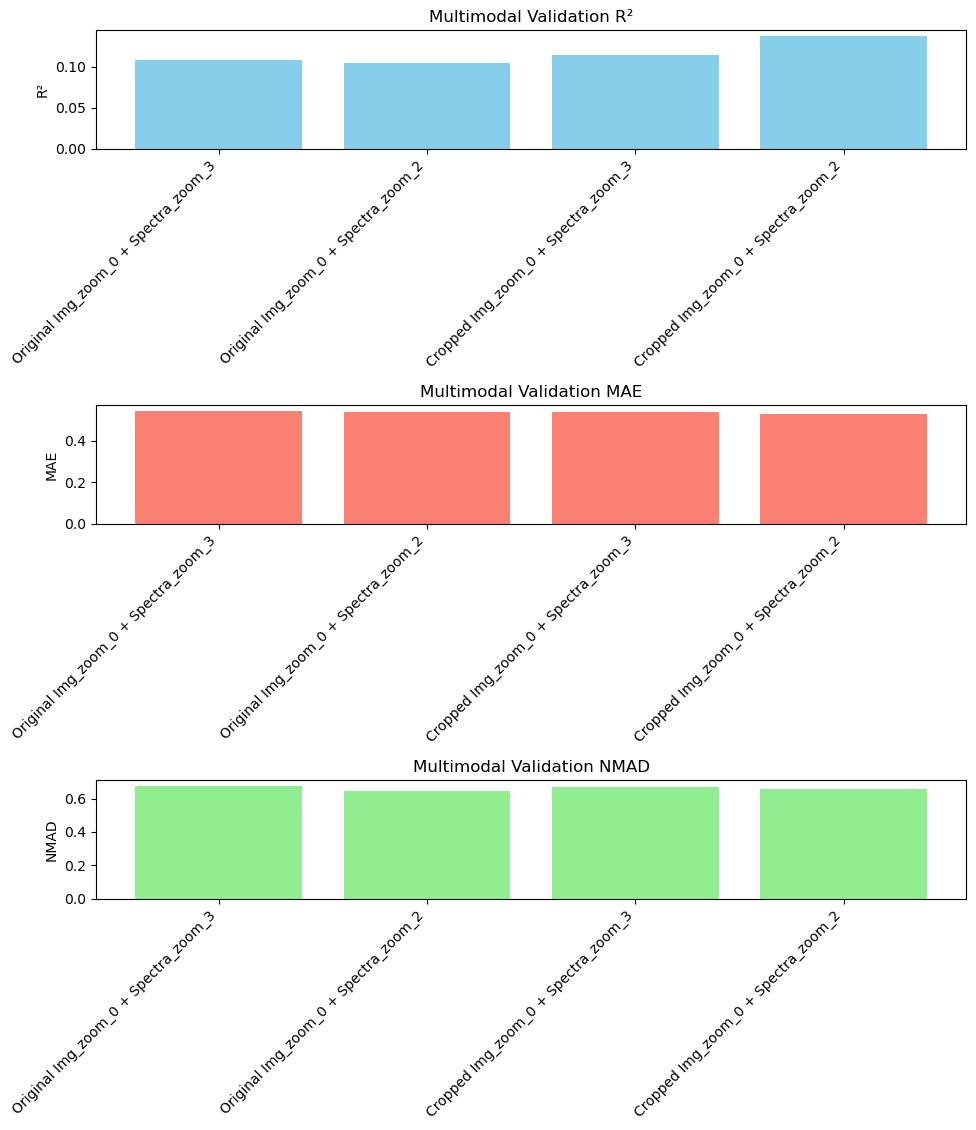

In [31]:
width = 0.25
x = np.arange(len(keys))
fig, axs = plt.subplots(3, 1, figsize=(10,12))
axs[0].bar(x, r2_vals, color='skyblue')
axs[0].set_xticks(x)
axs[0].set_xticklabels(keys, rotation=45, ha='right')
axs[0].set_ylabel("R²")
axs[0].set_title("Multimodal Validation R²")
axs[1].bar(x, mae_vals, color='salmon')
axs[1].set_xticks(x)
axs[1].set_xticklabels(keys, rotation=45, ha='right')
axs[1].set_ylabel("MAE")
axs[1].set_title("Multimodal Validation MAE")
axs[2].bar(x, nmad_vals, color='lightgreen')
axs[2].set_xticks(x)
axs[2].set_xticklabels(keys, rotation=45, ha='right')
axs[2].set_ylabel("NMAD")
axs[2].set_title("Multimodal Validation NMAD")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [32]:
best_key = max(multimodal_results, key=lambda k: multimodal_results[k]['r2'])
best_res = multimodal_results[best_key]
print(f"\nBest overall combination: {best_key}")
print(f"R² = {best_res['r2']:.3f}, MAE = {best_res['mae']:.3f}, NMAD = {best_res['nmad']:.3f}")
print(f"Best Parameters: {best_res['best_params']}")


Best overall combination: Cropped Img_zoom_0 + Spectra_zoom_2
R² = 0.138, MAE = 0.529, NMAD = 0.657
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt'}


# VGG NET:

## Spectrum and Photo separately:

In [33]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()
    def forward(self, output, target):
        if target.dim() == 1:
            target = target.view(-1, 1)
        return F.mse_loss(output, target)

class VGGNet12(nn.Module):
    def __init__(self, input_channels, input_height, input_width, dropout=0.5):
        super(VGGNet12, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        pool_h = max(1, input_height // 8)
        pool_w = max(1, input_width // 8)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((pool_h, pool_w))
        fc_input_dim = 256 * pool_h * pool_w
        self.fc1 = nn.Linear(fc_input_dim, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def run_skorch_grid_search(X, Y, input_channels, input_height, input_width, param_grid):
    net = NeuralNetRegressor(
        module=VGGNet12,
        module__input_channels=input_channels,
        module__input_height=input_height,
        module__input_width=input_width,
        module__dropout=0.5,
        max_epochs=50,
        lr=0.001,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=5))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    gs = GridSearchCV(net, param_grid, scoring='r2', cv=3)
    gs.fit(X, Y)
    best_score = gs.best_score_
    best_params = gs.best_params_
    best_model = gs.best_estimator_
    Y_pred = best_model.predict(X)
    Y_pred = np.nan_to_num(Y_pred, nan=0.0)
    mae = mean_absolute_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    error = Y_pred - Y
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    return best_score, best_params, mae, r2, nmad

In [34]:
vgg_param_grid = {
    'module__dropout': [0.3],
    'lr': [0.001],
    'callbacks__early_stopping__patience': [1]
}

results_vgg = {'Original Img': {}, 'Cropped Img': {}, 'Spectra': {}}

def run_experiment(modality, X_list, selected_Y, input_channels_override=None, input_height_override=None, input_width_override=None):
    res = {}
    for zoom in range(4):
        X = X_list[zoom].astype(np.float32)
        input_channels = input_channels_override if input_channels_override is not None else X.shape[1]
        input_height = input_height_override if input_height_override is not None else X.shape[2]
        input_width = input_width_override if input_width_override is not None else X.shape[3]
        n_samples = X.shape[0]
        Y_current = selected_Y[:n_samples].astype(np.float32)
        best_score, best_params, mae, r2, nmad = run_skorch_grid_search(
            X, Y_current, input_channels, input_height, input_width, vgg_param_grid
        )
        res[f'zoom_{zoom}'] = {
            'best_cv_score': best_score,
            'best_params': best_params,
            'mae': mae,
            'r2': r2,
            'nmad': nmad
        }
        print(f"{modality} zoom {zoom}: CV Score = {best_score:.3f}, MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")
    return res

selected_Y_flag0 = cleaned_sfrs_flag0.loc[selected_flag0_clean]["AVG"].values.astype(np.float32)

In [35]:
results_vgg['Original Img'] = run_experiment("Original Img", orig_images_flag0, selected_Y_flag0)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5253        0.5325  3.4541
      2        0.5238        0.5322  3.1194
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5397        0.5637  3.1220
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5232        0.5776  3.1133
      2        0.5201        0.5702  3.1035
      3        0.5207        0.5685  3.1047
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5381        0.5515  4.6752
      2        0.5309        0.5486  4.6651
      3        0.5291        0.5453  4.6721
      4        0.5288        0.5443  4.6751
Stopping sinc

In [36]:
results_vgg['Cropped Img'] = run_experiment("Cropped Img", orig_images_flag0_crop, selected_Y_flag0)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5298        0.5326  1.3652
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5475        0.5744  1.3777
      2        0.5386        0.5664  1.3757
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5270        0.5753  1.3783
      2        0.5235        0.5611  1.3755
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5354        0.5413  2.0696
Stopping since valid_loss has not improved in the last 1 epochs.
Cropped Img zoom 0: CV Score = -0.004, MAE = 0.611, R2 = -0.001, NMAD = 0.840, Best Params = {'callbacks__early_stopping__pa

### Spectra:

In [37]:
spectra_list = []
for zoom in range(4):
    X_spec = normalized_filtered_spectra[zoom].astype(np.float32)
    if len(X_spec.shape) == 2:
        n_samples, n_features = X_spec.shape
        h = int(math.sqrt(n_features))
        if h < 4:
            h = 4
        w = math.ceil(n_features / h)
        if w < 4:
            w = 4
        total_elements = h * w
        if total_elements > n_features:
            pad_length = total_elements - n_features
            padding = np.zeros((n_samples, pad_length), dtype=X_spec.dtype)
            X_spec = np.concatenate([X_spec, padding], axis=1)
        X_spec = X_spec.reshape(n_samples, 1, h, w)
    elif len(X_spec.shape) == 3:
        X_spec = X_spec[:, None, :, :]
    spectra_list.append(X_spec)

In [39]:
input_channels_spec = spectra_list[0].shape[1]
input_height_spec = spectra_list[0].shape[2]
input_width_spec = spectra_list[0].shape[3]

results_vgg['Spectra'] = run_experiment("Spectra", spectra_list, selected_Y_flag0,
                                        input_channels_override=input_channels_spec,
                                        input_height_override=input_height_spec,
                                        input_width_override=input_width_spec)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5326        0.5323  3.6308
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5466        0.5675  3.5975
      2        0.5371        0.5633  3.5824
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5303        0.5879  3.6258
      2        0.5236        0.5777  3.6252
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5337        0.5430  5.4402
Stopping since valid_loss has not improved in the last 1 epochs.
Spectra zoom 0: CV Score = -0.005, MAE = 0.611, R2 = -0.000, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patien

/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
   

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5411        0.5711  1.5817
Stopping since valid_loss has not improved in the last 1 epochs.
Stopping since valid_loss has not improved in the last 1 epochs.


/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5360        0.5536  2.3644
      2        0.5337        0.5492  2.3591
Stopping since valid_loss has not improved in the last 1 epochs.
Spectra zoom 2: CV Score = nan, MAE = 0.612, R2 = -0.004, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5308        0.5361  1.2162
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5409        0.5436  1.1885
Stopping since valid_loss has not improved in the last 1 epochs.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5321        0.5845  1.1822
Stopping since valid_loss has not improved in the last 1 epochs.
  

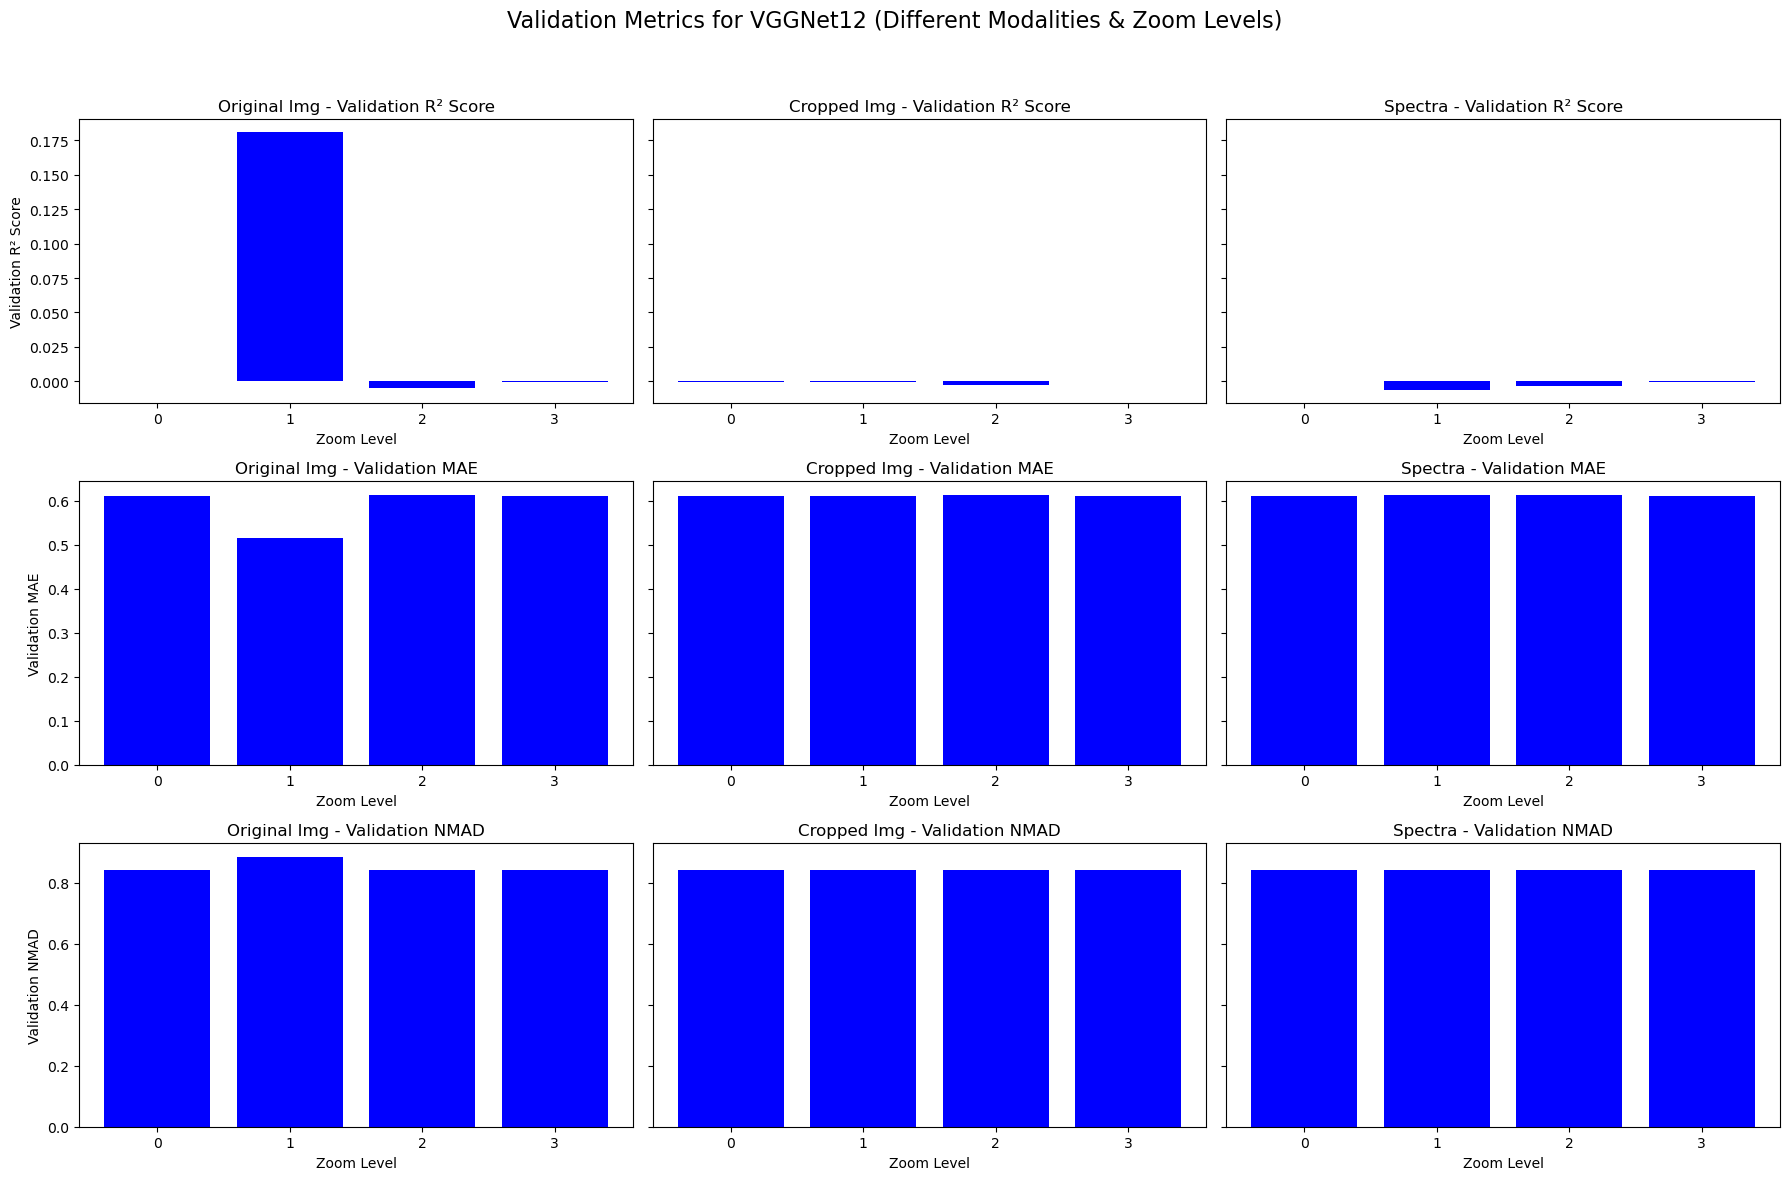

In [40]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharey='row')
for i, metric in enumerate(metrics):
    for j, modality in enumerate(modalities):
        zooms = []
        values = []
        for zoom in range(4):
            key = f'zoom_{zoom}'
            zooms.append(zoom)
            values.append(results_vgg[modality][key][metric])
        axs[i, j].bar(zooms, values, color='blue')
        axs[i, j].set_title(f"{modality} - {titles[metric]}")
        axs[i, j].set_xlabel("Zoom Level")
        axs[i, j].set_xticks(zooms)
        if j == 0:
            axs[i, j].set_ylabel(titles[metric])
plt.suptitle("Validation Metrics for VGGNet12 (Different Modalities & Zoom Levels)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [41]:
for modality in modalities:
    print(f"\nTop 2 best results for {modality}:")
    sorted_results = sorted(results_vgg[modality].items(), key=lambda x: x[1]['r2'], reverse=True)
    for i in range(min(2, len(sorted_results))):
        zoom_key, res = sorted_results[i]
        print(f"{zoom_key}: MAE = {res['mae']:.3f}, R2 = {res['r2']:.3f}, NMAD = {res['nmad']:.3f}, Best Params = {res['best_params']}")

best_key = max(sum([list(results_vgg[m].items()) for m in modalities], []), key=lambda x: x[1]['r2'])[0]
best_overall = None
for m in modalities:
    if best_key in results_vgg[m]:
        best_overall = results_vgg[m][best_key]
        best_modality = m
        break
print(f"\nBest overall combination: {best_modality} {best_key}")
print(f"R² = {best_overall['r2']:.3f}, MAE = {best_overall['mae']:.3f}, NMAD = {best_overall['nmad']:.3f}")
print(f"Best Parameters: {best_overall['best_params']}")


Top 2 best results for Original Img:
zoom_1: MAE = 0.515, R2 = 0.181, NMAD = 0.885, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}
zoom_0: MAE = 0.611, R2 = -0.000, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}

Top 2 best results for Cropped Img:
zoom_3: MAE = 0.611, R2 = -0.000, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}
zoom_1: MAE = 0.611, R2 = -0.001, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}

Top 2 best results for Spectra:
zoom_0: MAE = 0.611, R2 = -0.000, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}
zoom_3: MAE = 0.611, R2 = -0.001, NMAD = 0.840, Best Params = {'callbacks__early_stopping__patience': 1, 'lr': 0.001, 'module__dropout': 0.3}

Best overall combination: Original Img z

## Multimodal:

In [42]:
class EarlyFusionNet(nn.Module):
    def __init__(self, input_channels_photo, input_channels_spec, height, width, dropout=0.5):
        super(EarlyFusionNet, self).__init__()
        total_channels = input_channels_photo + input_channels_spec
        self.block1 = nn.Sequential(
            nn.Conv2d(total_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        h = height // 8
        w = width // 8
        self.fc1 = nn.Linear(256 * h * w, 512)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(128, 1)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class LateFusionNet(nn.Module):
    def __init__(self, input_channels_photo, input_height_photo, input_width_photo,
                 input_channels_spec, input_height_spec, input_width_spec, dropout=0.5):
        super(LateFusionNet, self).__init__()
        self.photo_block1 = nn.Sequential(
            nn.Conv2d(input_channels_photo, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.photo_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.photo_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        h_p = input_height_photo // 8
        w_p = input_width_photo // 8
        self.photo_fc = nn.Sequential(
            nn.Linear(256 * h_p * w_p, 128),
            nn.ReLU(inplace=True)
        )
        self.spec_block1 = nn.Sequential(
            nn.Conv2d(input_channels_spec, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.spec_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.spec_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        h_s = input_height_spec // 8
        w_s = input_width_spec // 8
        self.spec_fc = nn.Sequential(
            nn.Linear(256 * h_s * w_s, 128),
            nn.ReLU(inplace=True)
        )
        self.fusion_fc = nn.Sequential(
            nn.Linear(128+128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
    def forward(self, X):
        x_photo = X['photo']
        x_spec = X['spec']
        p = self.photo_block1(x_photo)
        p = self.photo_block2(p)
        p = self.photo_block3(p)
        p = p.view(p.size(0), -1)
        p = self.photo_fc(p)
        s = self.spec_block1(x_spec)
        s = self.spec_block2(s)
        s = self.spec_block3(s)
        s = s.view(s.size(0), -1)
        s = self.spec_fc(s)
        fusion = torch.cat([p, s], dim=1)
        out = self.fusion_fc(fusion)
        return out        

In [43]:
multimodal_param_grid = {
    'module__dropout': [0.3],
    'lr': [0.001],
    'callbacks__early_stopping__patience': [1]
}

def resize_array(arr, target_height, target_width):
    tensor = torch.from_numpy(arr)
    resized = F.interpolate(tensor, size=(target_height, target_width), mode='bilinear', align_corners=False)
    return resized.numpy()

def run_skorch_grid_search_multimodal(net, X, Y, param_grid):
    gs = GridSearchCV(net, param_grid, scoring='r2', cv=3)
    gs.fit(X, Y)
    best_score = gs.best_score_
    best_params = gs.best_params_
    best_model = gs.best_estimator_
    Y_pred = best_model.predict(X)
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    error = Y_pred - Y
    nmad = 1.4826 * np.median(np.abs(error - np.median(error)))
    return best_score, best_params, mae, r2, nmad

def run_multimodal_early_fusion(photo_array, spec_array, selected_Y):
    n_samples = min(photo_array.shape[0], spec_array.shape[0], len(selected_Y))
    X_photo = photo_array[:n_samples]
    X_spec = spec_array[:n_samples]
    if X_photo.shape[2] != X_spec.shape[2] or X_photo.shape[3] != X_spec.shape[3]:
        X_spec = resize_array(X_spec, X_photo.shape[2], X_photo.shape[3])
    Y_current = selected_Y[:n_samples].astype(np.float32)
    X_multimodal = np.concatenate([X_photo, X_spec], axis=1)
    input_height = X_multimodal.shape[2]
    input_width = X_multimodal.shape[3]
    net = NeuralNetRegressor(
        module=EarlyFusionNet,
        module__dropout=0.5,
        max_epochs=50,
        lr=0.001,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=5))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    net.set_params(module__init=lambda: EarlyFusionNet(X_photo.shape[1], X_spec.shape[1], input_height, input_width, dropout=0.5))
    return run_skorch_grid_search_multimodal(net, X_multimodal, Y_current, multimodal_param_grid)
    
def run_multimodal_late_fusion(photo_array, spec_array, selected_Y):
    n_samples = min(photo_array.shape[0], spec_array.shape[0], len(selected_Y))
    X_photo = photo_array[:n_samples]
    X_spec = spec_array[:n_samples]
    Y_current = selected_Y[:n_samples].astype(np.float32)
    input_channels_photo = X_photo.shape[1]
    input_height_photo = X_photo.shape[2]
    input_width_photo = X_photo.shape[3]
    input_channels_spec = X_spec.shape[1]
    input_height_spec = X_spec.shape[2]
    input_width_spec = X_spec.shape[3]
    net = NeuralNetRegressor(
        module=LateFusionNet,
        module__input_channels_photo=input_channels_photo,
        module__input_height_photo=input_height_photo,
        module__input_width_photo=input_width_photo,
        module__input_channels_spec=input_channels_spec,
        module__input_height_spec=input_height_spec,
        module__input_width_spec=input_width_spec,
        module__dropout=0.5,
        max_epochs=50,
        lr=0.001,
        optimizer=torch.optim.Adam,
        batch_size=32,
        iterator_train__shuffle=True,
        callbacks=[('early_stopping', EarlyStopping(patience=5))],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        criterion=CustomMSELoss,
    )
    X_input = {'photo': X_photo, 'spec': X_spec}
    return run_skorch_grid_search_multimodal(net, X_input, Y_current, multimodal_param_grid)


In [44]:
photo_candidates = []
for zoom in range(4):
    candidate = ("Original Img", zoom, results_vgg['Original Img'][f'zoom_{zoom}']['mae'], orig_images_flag0[zoom])
    photo_candidates.append(candidate)
for zoom in range(4):
    candidate = ("Cropped Img", zoom, results_vgg['Cropped Img'][f'zoom_{zoom}']['mae'], orig_images_flag0_crop[zoom])
    photo_candidates.append(candidate)
photo_candidates = sorted(photo_candidates, key=lambda x: x[2])
top_photo = photo_candidates[:2]

spectra_candidates = []
for zoom in range(4):
    candidate = ("Spectra", zoom, results_vgg['Spectra'][f'zoom_{zoom}']['mae'], spectra_list[zoom])
    spectra_candidates.append(candidate)
spectra_candidates = sorted(spectra_candidates, key=lambda x: x[2])
top_spectra = spectra_candidates[:2]

In [45]:
# multimodal_results = {}
# fusion_types = ['Early Fusion', 'Late Fusion']
# for fusion in fusion_types:
#     for photo in top_photo:
#         for spec in top_spectra:
#             photo_key = f"{photo[0]}_zoom_{photo[1]}"
#             spec_key = f"{spec[0]}_zoom_{spec[1]}"
#             comb_key = f"{photo_key} + {spec_key} ({fusion})"
#             if fusion == 'Early Fusion':
#                 best_score, best_params, mae, r2, nmad = run_multimodal_early_fusion(photo[3], spec[3], selected_Y_flag0)
#             else:
#                 best_score, best_params, mae, r2, nmad = run_multimodal_late_fusion(photo[3], spec[3], selected_Y_flag0)
#             multimodal_results[comb_key] = {
#                 'best_cv_score': best_score,
#                 'best_params': best_params,
#                 'mae': mae,
#                 'r2': r2,
#                 'nmad': nmad
#             }
#             print(f"{comb_key}: CV Score = {best_score:.3f}, MAE = {mae:.3f}, R2 = {r2:.3f}, NMAD = {nmad:.3f}, Best Params = {best_params}")

# keys = list(multimodal_results.keys())
# r2_vals = [multimodal_results[k]['r2'] for k in keys]
# mae_vals = [multimodal_results[k]['mae'] for k in keys]
# nmad_vals = [multimodal_results[k]['nmad'] for k in keys]

In [46]:
# width = 0.25
# x = np.arange(len(keys))
# fig, axs = plt.subplots(3, 1, figsize=(12,12))
# axs[0].bar(x, r2_vals, color='skyblue')
# axs[0].set_xticks(x)
# axs[0].set_xticklabels(keys, rotation=45, ha='right')
# axs[0].set_ylabel("R²")
# axs[0].set_title("Multimodal Validation R²")
# axs[1].bar(x, mae_vals, color='salmon')
# axs[1].set_xticks(x)
# axs[1].set_xticklabels(keys, rotation=45, ha='right')
# axs[1].set_ylabel("MAE")
# axs[1].set_title("Multimodal Validation MAE")
# axs[2].bar(x, nmad_vals, color='lightgreen')
# axs[2].set_xticks(x)
# axs[2].set_xticklabels(keys, rotation=45, ha='right')
# axs[2].set_ylabel("NMAD")
# axs[2].set_title("Multimodal Validation NMAD")
# plt.tight_layout(rect=[0,0,1,0.95])
# plt.show()

In [47]:
# best_key = max(multimodal_results, key=lambda k: multimodal_results[k]['r2'])
# best_res = multimodal_results[best_key]
# print(f"\nBest overall combination: {best_key}")
# print(f"R² = {best_res['r2']:.3f}, MAE = {best_res['mae']:.3f}, NMAD = {best_res['nmad']:.3f}")
# print(f"Best Parameters: {best_res['best_params']}")